## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')

CPU times: user 2.29 s, sys: 371 ms, total: 2.66 s
Wall time: 2.7 s


In [3]:
s1

AnnData object with n_obs × n_vars = 5257 × 38459 
    obs: 'ken_filter'

In [4]:
# checkpoint raw data for future filtering
s1.raw = s1

In [5]:
s1.var_names[s1.var_names.str.contains('mt-')] # check gene label format

Index(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1',
       'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'mt-Rnr1',
       'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te', 'mt-Tf', 'mt-Tg',
       'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn',
       'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2', 'mt-Tt', 'mt-Tv',
       'mt-Tw', 'mt-Ty'],
      dtype='object', name='index')

In [6]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 2 s, sys: 509 ms, total: 2.5 s
Wall time: 2.5 s


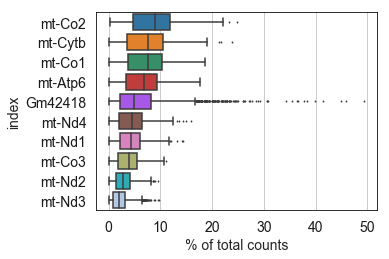

In [7]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).

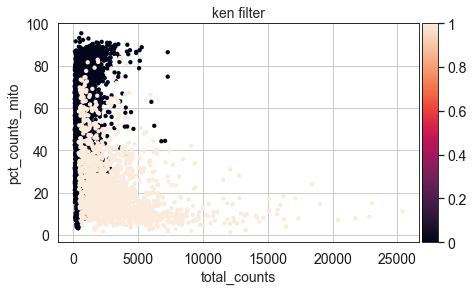

In [8]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Find inflection point

Inflection point at index
bcEZXH    1457
bcAIGS    2043
bcANEG     632
bcFUIP    3914
bcEHCB    5256
Name: total_counts, dtype: int64 for [0, 20, 40, 70, 100] percentiles of greatest secant distances


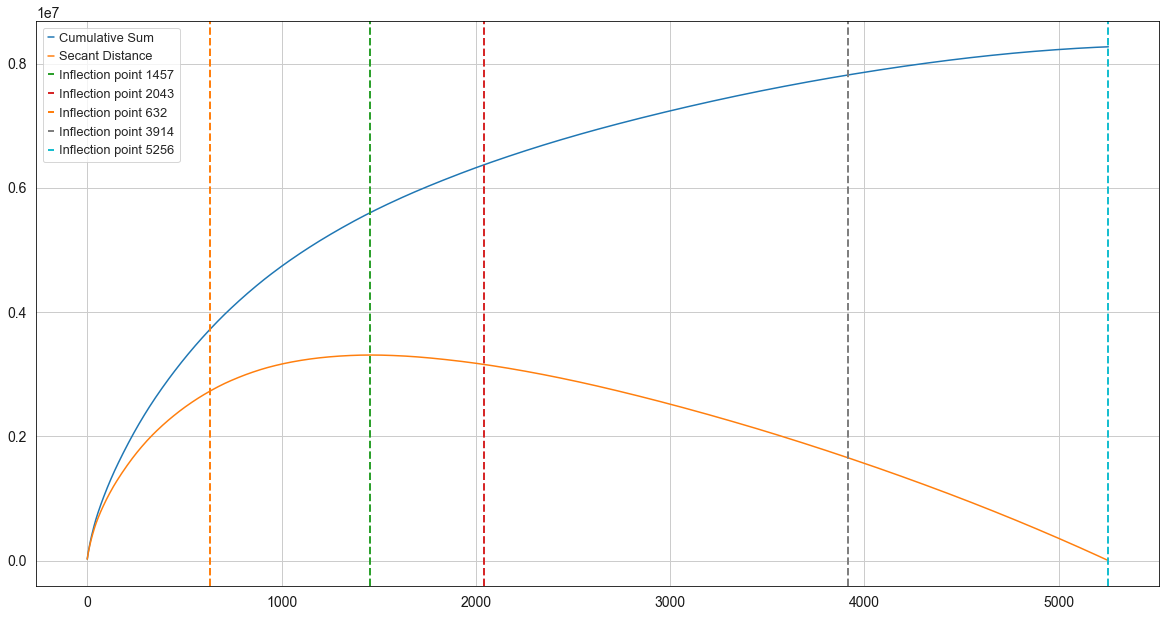

In [9]:
find_inflection(s1, inflection_percentiles = [0,20,40,70,100])

In [10]:
s1.obs['total_counts'][3914] # see the total counts for the cutoff point

518.0

In [11]:
# create new "observation" as empty droplet label
s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][3914], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [12]:
s1.obs['bagging_empty'].value_counts()

0    3913
1    1344
Name: bagging_empty, dtype: int64

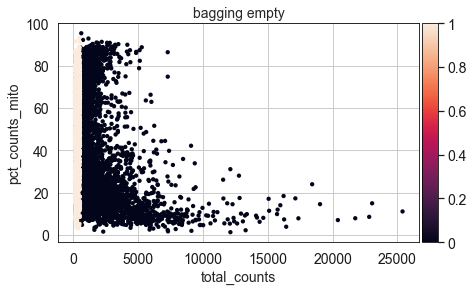

In [13]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_empty', size=75)

### Normalize and perform linear dimensionality reduction with PCA

In [14]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 1.23 s, sys: 155 ms, total: 1.39 s
Wall time: 1.39 s


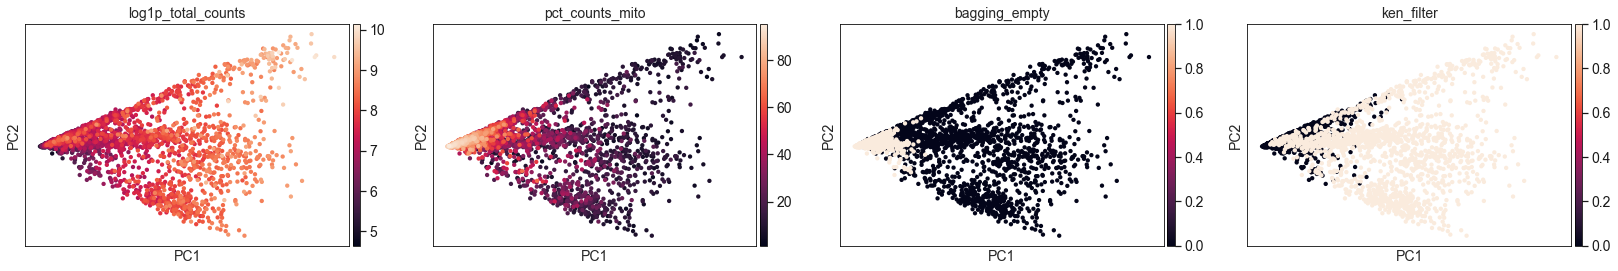

CPU times: user 35.7 s, sys: 2.68 s, total: 38.3 s
Wall time: 6.49 s


In [15]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','ken_filter'], ncols=4, size=75)

---
### PU Bagging

In [16]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['bagging_empty'].copy(deep=True) # training labels are from .obs df

In [17]:
%%time

bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

CPU times: user 3.39 s, sys: 235 ms, total: 3.63 s
Wall time: 28.3 s


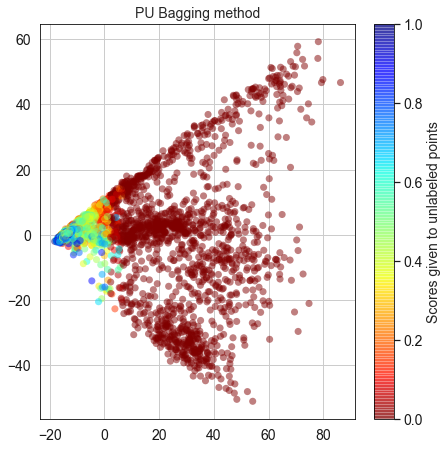

In [18]:
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

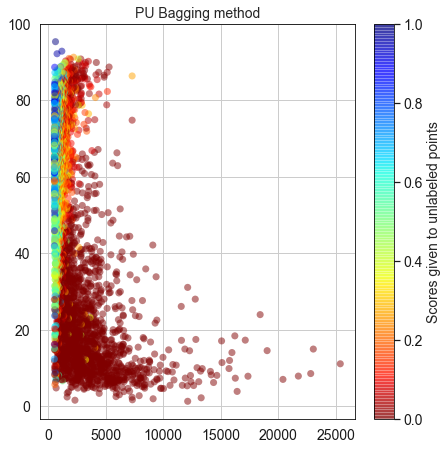

In [19]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

In [20]:
s1.obs['bagging_result'] = np.where(results_bagging_empty!=0, 1, 0)

In [21]:
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [22]:
s1.obs['bagging_result'].value_counts()

1    3911
0    1346
Name: bagging_result, dtype: int64

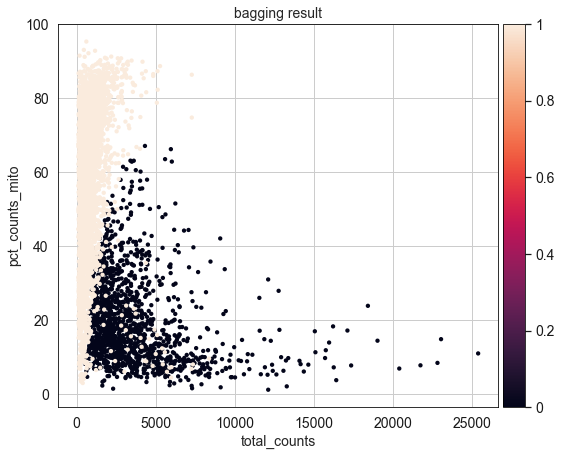

In [23]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_result', size=75)

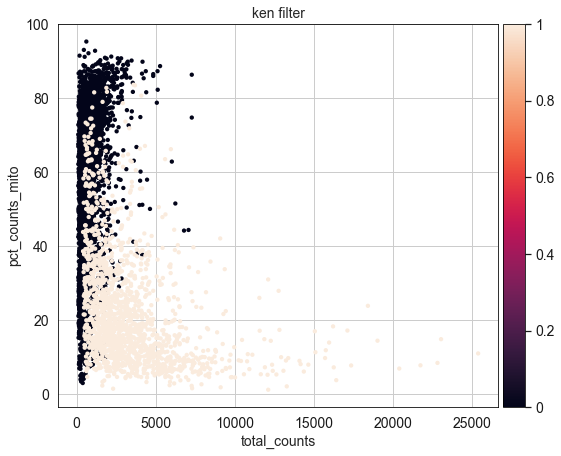

In [24]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [25]:
s1_notempty = s1[s1.obs['bagging_result']==0,:].copy() # move forward with non-empty droplets

In [26]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [27]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 327 ms, sys: 17 ms, total: 344 ms
Wall time: 344 ms


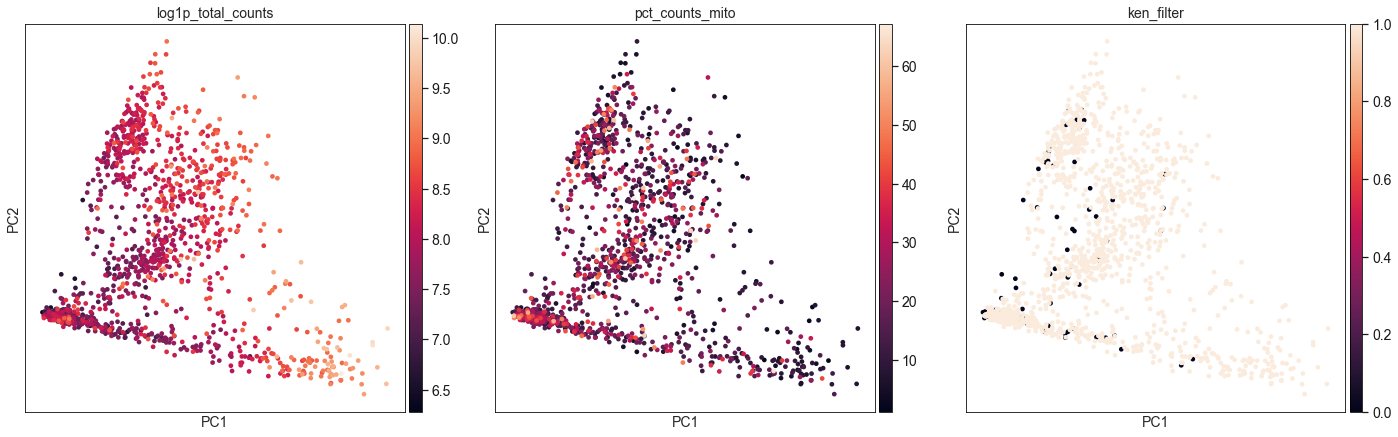

CPU times: user 16.3 s, sys: 1.82 s, total: 18.2 s
Wall time: 2.36 s


In [28]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

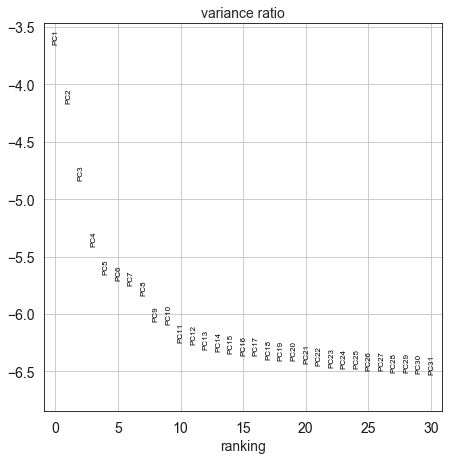

In [29]:
sc.pl.pca_variance_ratio(s1_notempty, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [30]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_notempty, random_state=1) # perform UMAP

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 6.61 s, sys: 200 ms, total: 6.81 s
Wall time: 5.91 s


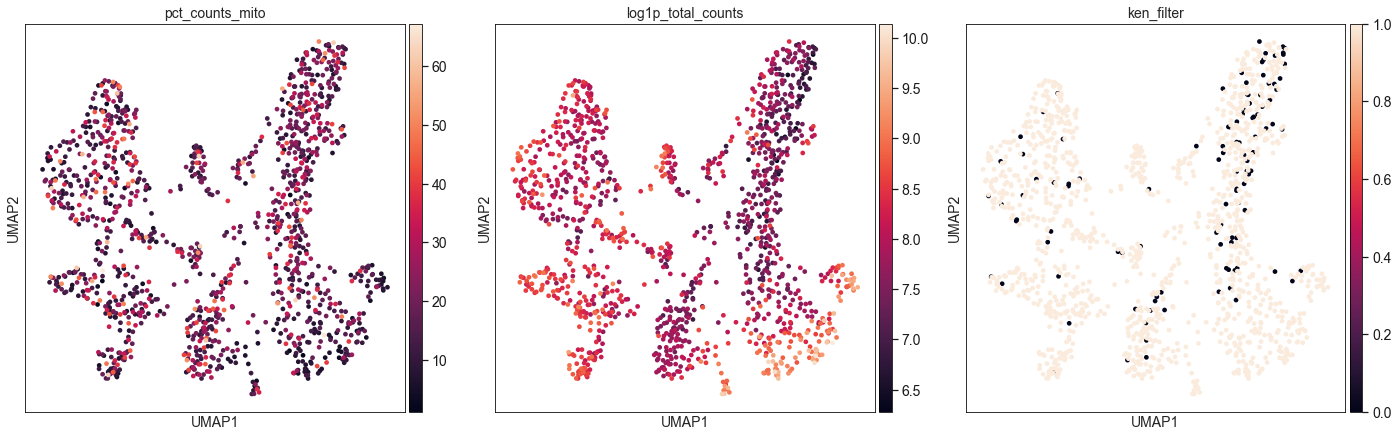

In [31]:
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [33]:
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


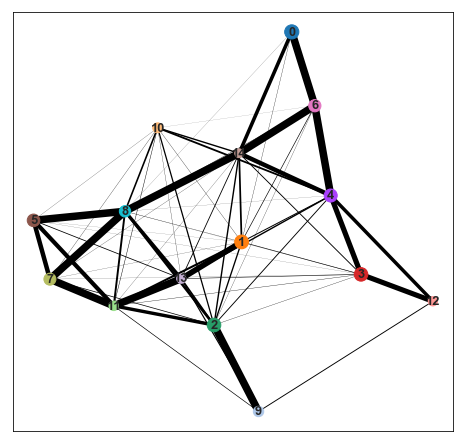

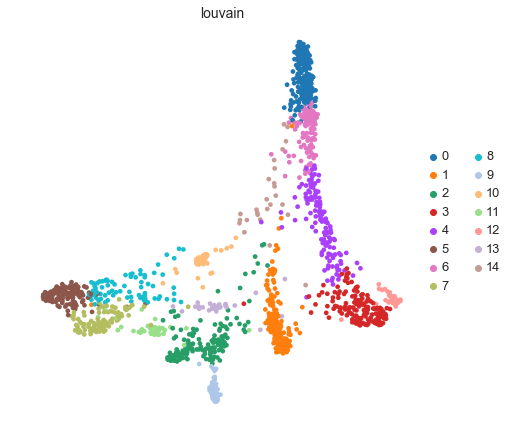

In [34]:
sc.tl.paga(s1_notempty) #perform PAGA
sc.pl.paga(s1_notempty)
sc.tl.draw_graph(s1_notempty, init_pos='paga')
sc.pl.draw_graph(s1_notempty, color='louvain', frameon=False)

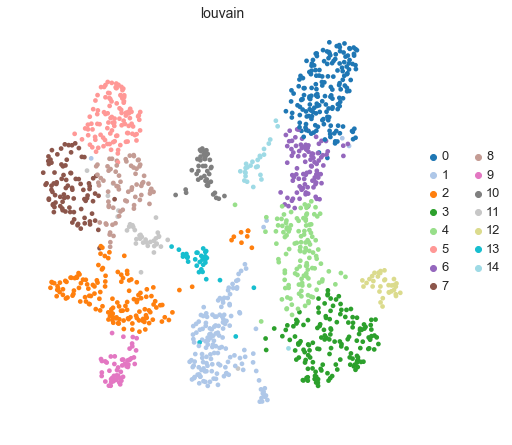

In [37]:
sc.pl.umap(s1_notempty, color=['louvain'], frameon=False)

---
## Ken Filtering

In [38]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [39]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [40]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 378 ms, sys: 21.1 ms, total: 399 ms
Wall time: 399 ms


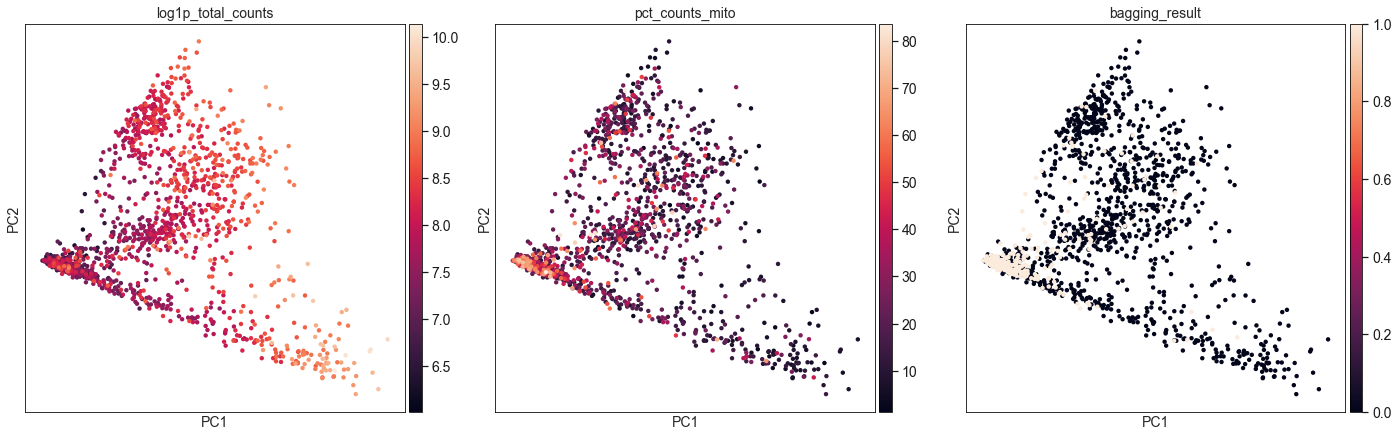

CPU times: user 17.1 s, sys: 1.95 s, total: 19 s
Wall time: 2.54 s


In [41]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','bagging_result'], ncols=3)

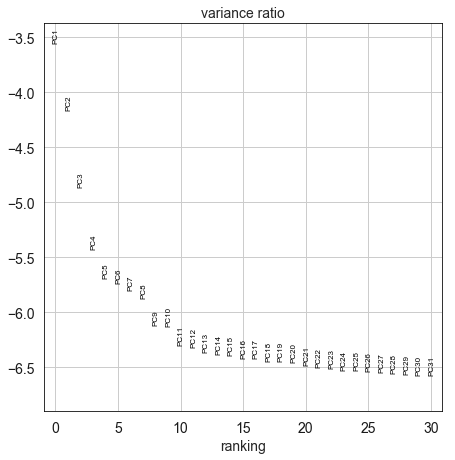

In [42]:
sc.pl.pca_variance_ratio(s1_gold, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [43]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_gold, random_state=1) # perform UMAP

CPU times: user 3.2 s, sys: 151 ms, total: 3.35 s
Wall time: 2.39 s


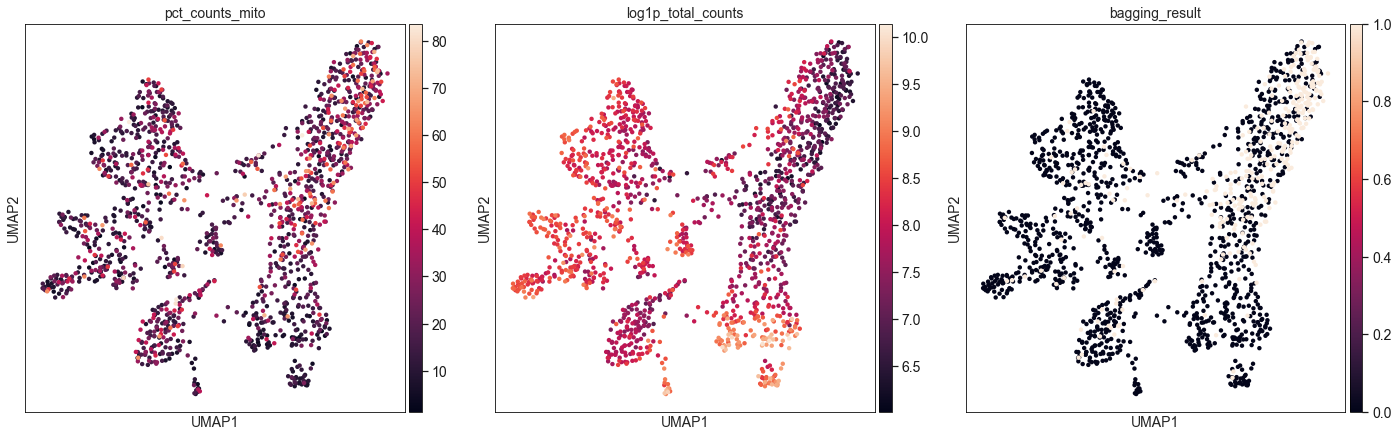

In [44]:
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','bagging_result'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [45]:
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


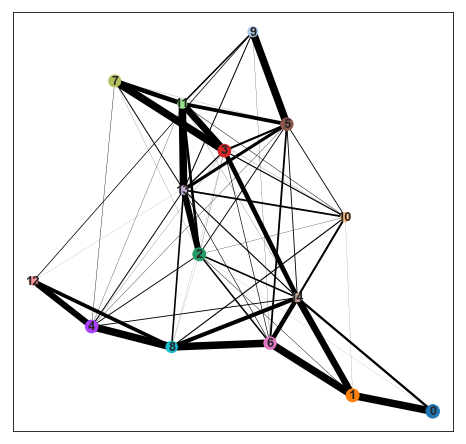

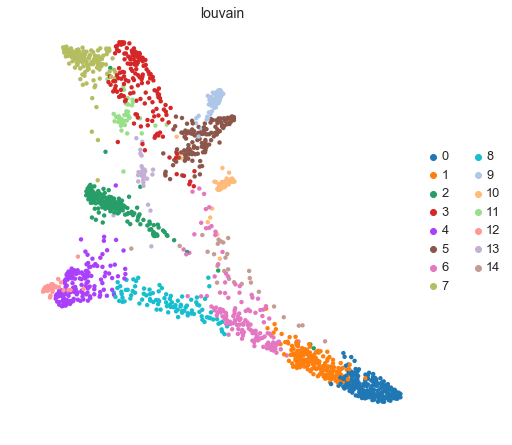

In [46]:
sc.tl.paga(s1_gold) #perform PAGA
sc.pl.paga(s1_gold)
sc.tl.draw_graph(s1_gold, init_pos='paga')
sc.pl.draw_graph(s1_gold, color='louvain', frameon=False)

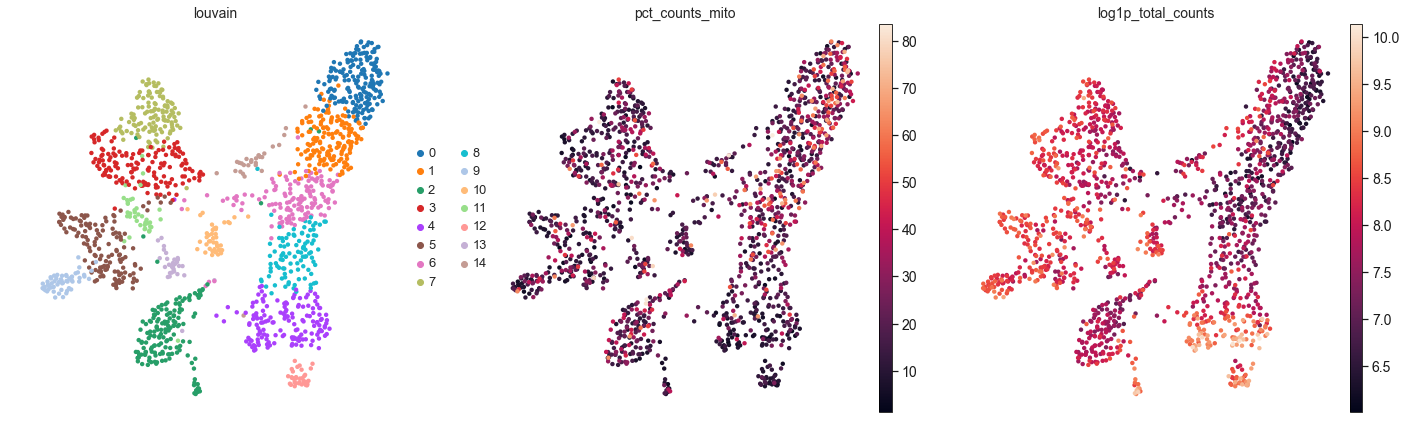

In [48]:
sc.pl.umap(s1_gold, color=['louvain','pct_counts_mito','log1p_total_counts'], frameon=False)